<a href="https://colab.research.google.com/github/SergiiRv/Chest-X-ray-prediction/blob/main/Copy_of_XrayPredictSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io

import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

plt.ion()   # interactive mode

In [ ]:
"""
import os
import numpy as np
import pandas as pd   

rootline_normal = 'C://-------------//normal'
rootline_opacity ="C://--------------//opacity"
list_normal = os.listdir(rootline_normal)
list_opacity = os.listdir(rootline_opacity)
class_normal = np.zeros(len(list_normal))
class_opacity = np.ones(len(list_opacity))
all_file = list_normal + list_opacity
all_Y_list = list(class_normal) + list(class_opacity)
all_Y = np.append(class_normal, class_opacity)

datadict = {'file_name': all_file, 'diagnose': all_Y}

df_data = pd.DataFrame(datadict)

df_data.to_csv('datalist.csv')

if len(os.listdir())<=2:
  os.mkdir('XRayScans/')
"""

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
allfilelist = os.listdir('-----------------------------')
print(allfilelist[0:10])
csvpath = '---------------------------/datalist.csv'
if 'datalist.csv' in allfilelist:
  scans_list = pd.read_csv(csvpath)
  print(scans_list.head(10), '\n', scans_list.tail(10))

['NORMAL2-IM-1134-0001.jpeg', 'NORMAL2-IM-1118-0001.jpeg', 'NORMAL2-IM-1126-0001.jpeg', 'NORMAL2-IM-1138-0001.jpeg', 'NORMAL2-IM-1125-0001.jpeg', 'NORMAL2-IM-1135-0001.jpeg', 'NORMAL2-IM-1124-0001.jpeg', 'NORMAL2-IM-1130-0001.jpeg', 'NORMAL2-IM-1105-0001.jpeg', 'NORMAL2-IM-1117-0001.jpeg']
   Unnamed: 0               file_name  diagnose
0           0       IM-0001-0001.jpeg       0.0
1           1       IM-0003-0001.jpeg       0.0
2           2       IM-0005-0001.jpeg       0.0
3           3       IM-0006-0001.jpeg       0.0
4           4       IM-0007-0001.jpeg       0.0
5           5       IM-0009-0001.jpeg       0.0
6           6       IM-0010-0001.jpeg       0.0
7           7  IM-0011-0001-0001.jpeg       0.0
8           8  IM-0011-0001-0002.jpeg       0.0
9           9       IM-0011-0001.jpeg       0.0 
       Unnamed: 0                     file_name  diagnose
5846        5846     person997_virus_1678.jpeg       1.0
5847        5847  person998_bacteria_2927.jpeg       1.0
5848    

<class 'str'> 17 IM-0309-0001.jpeg
<class 'int'> 0


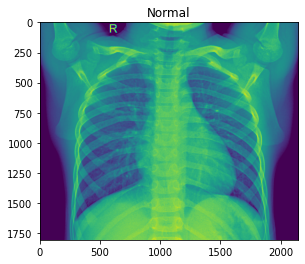

In [ ]:
n = 200
img_filename = list(scans_list.file_name)[n]
print(type(img_filename), len(img_filename), img_filename)
target = int(list(scans_list.diagnose)[n])
print(type(target), target)
image = io.imread(os.path.join('/content/gdrive/-----------/', img_filename))
if target == 0:
  diag = 'Normal'
else:
  diag = 'Opasity'

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('{}'.format(diag))
plt.imshow(image)
plt.show()

<class 'str'> 26 person92_bacteria_450.jpeg
<class 'int'> 1


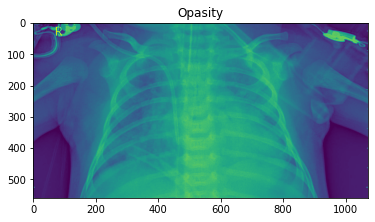

In [ ]:
n = -150
img_filename = list(scans_list.file_name)[n]
print(type(img_filename), len(img_filename), img_filename)
target = int(list(scans_list.diagnose)[n])
print(type(target), target)
image = io.imread(os.path.join('/content/gdrive/---------/', img_filename))
if target == 0:
  diag = 'Normal'
else:
  diag = 'Opasity'

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('{}'.format(diag))
plt.imshow(image)
plt.show()

In [ ]:
class ScanDataset(Dataset):
    """XRay dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        def rgb2gray(rgb):
          return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
        
        filelist = list(scans_list.file_name)
        target = list(scans_list.diagnose)

        img_name = os.path.join(self.root_dir,
                                filelist[idx])
        image = io.imread(img_name)
        if image.ndim > 2:
          image = rgb2gray(image)
        image = (image[:, :, np.newaxis]).astype(np.uint8)
        if self.transform:
            image = self.transform(image)

        y_label = torch.tensor(int(target[idx]))

        return (image, y_label)

In [ ]:
XRay_dataset = ScanDataset(csv_file=csvpath, root_dir='/content/gdrive/----------------------//')

In [ ]:
#testing if only graypicture in the Xscans
print(type(XRay_dataset[100][0]))
i=0
for el in XRay_dataset:
  i+=1
  if el[0].ndim > 2:
    print(i)

<class 'numpy.ndarray'>


In [ ]:
#Checking the diversity of the datatset
(ax, ay) = (1e9, 1e9)
reshapeX, reshapeY = 0, 0
ratio = 0
ratioL, axL, ayL = [], [], []
for (pic, Y) in XRay_dataset:
  h, w = pic.shape
  if ax>h :
    ax=h
    reshapeX +=1
  if ay>w:
    ay=w
    reshapeY +=1
  axL.append(h)
  ayL.append(w)
  #print(pic.shape, pic.ndim)
  ratio = h/w
  ratioL.append(ratio)





In [ ]:
print('ax=', ax)
print('ay=', ay)
ratioL = np.array(ratioL)
MeanRatio = ratioL.mean()
MedianRatio = np.median(ratioL)
MeanX = (np.array(axL)).mean()
MeanY = (np.array(ayL)).mean()
MedianX = np.median(axL)
MedianY = np.median(ayL)
print("average ratio=", MeanRatio, "Median ratio", MedianRatio)
print("average H=", MeanX, "Median H", MedianX)
print("average W=", MeanY, "Median W", MedianY)
if reshapeX>1 or reshapeY>1:
  print("need to adjust the sizes of pictures")


ax= 127
ay= 384
average ratio= 0.712904857460526 Median ratio 0.7062718531468531
average H= 970.6890368852459 Median H 888.0
average W= 1327.880806010929 Median W 1281.0
need to adjust the sizes of pictures


In [ ]:
print(len(XRay_dataset))
print(type(XRay_dataset[1][0]), type(torch.from_numpy(XRay_dataset[1][0])), (XRay_dataset[1][0]).shape)
pic, target = XRay_dataset[100]
print(pic.shape)
pic = torch.from_numpy(pic)
pic1 = torch.unsqueeze(pic, -3)
print(pic.shape, pic.dim(), pic1.shape, pic1.dim())

5856
<class 'numpy.ndarray'> <class 'torch.Tensor'> (1509, 2111)
(1615, 2172)
torch.Size([1615, 2172]) 2 torch.Size([1, 1615, 2172]) 3


torch.Size([1, 1317, 1857]) 3
torch.Size([3, 800, 1200])
tensor(32.1489) <class 'float'>
i= 0 Normal
torch.Size([1, 2325, 2450]) 3
torch.Size([3, 800, 1200])
tensor(0.) <class 'float'>
i= 1500 Normal
torch.Size([1, 592, 1024]) 3
torch.Size([3, 800, 1200])
tensor(26.9190) <class 'float'>
i= 3000 Opasity
torch.Size([1, 915, 1411]) 3
torch.Size([3, 800, 1200])
tensor(82.7614) <class 'float'>
i= 4500 Opasity


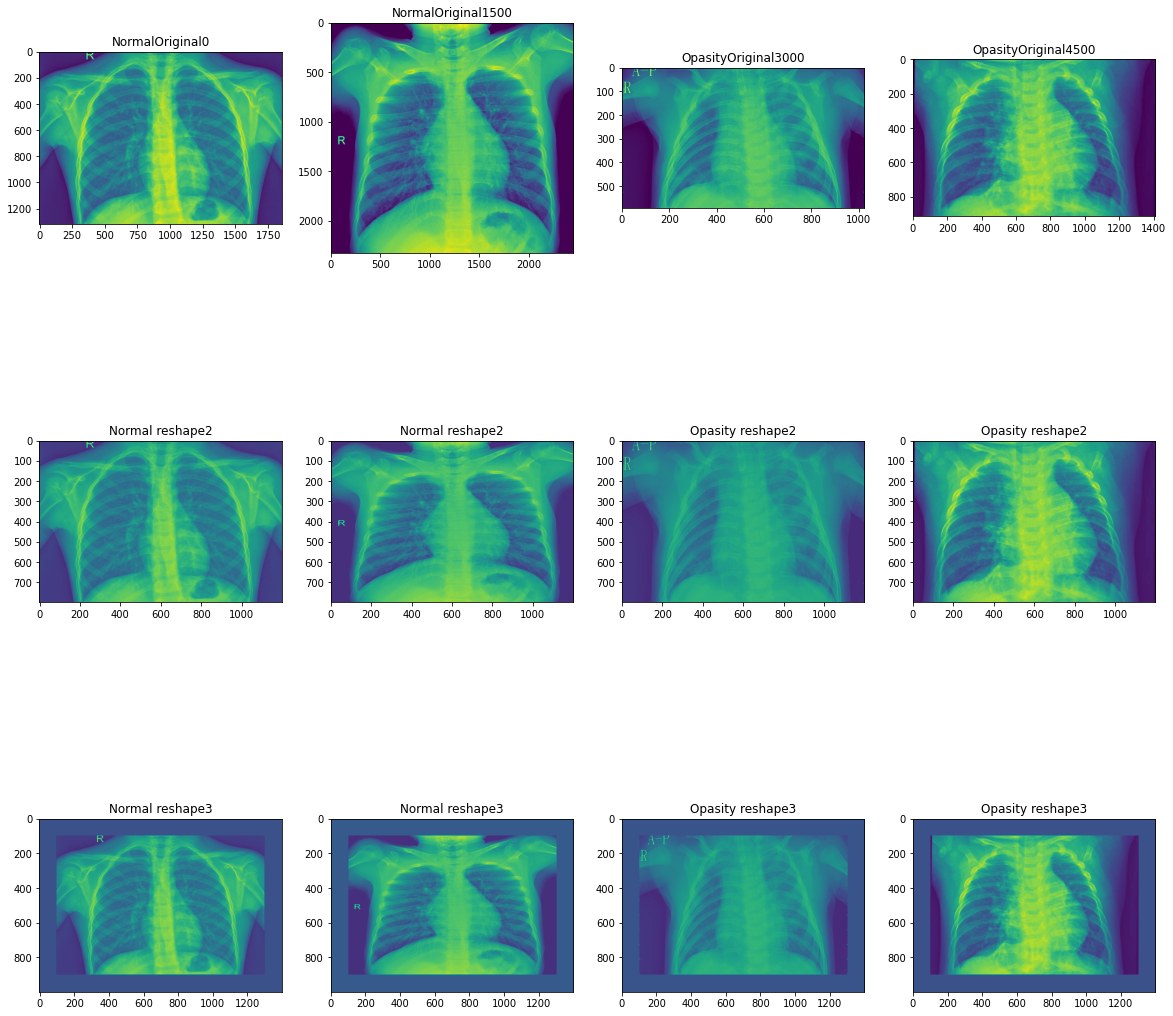

In [ ]:
#look after reshape transform
fig, axs = plt.subplots(3, len(range(0, len(XRay_dataset), 1500)))
fig.set_size_inches(20, 20)
ii=0

def my_transforms(image):
  im = torch.unsqueeze(torch.as_tensor(image), -3).to(torch.float) 
  print(im.shape, im.dim())
  image1 = transforms.functional.resize(im, (800, 1200), 3)
  image2 = transforms.functional.pad(image1, 100, 50)
  #image2 = transforms.functional.hflip(image1)
  print(torch.cat((image1, image1, image1)).shape)
  print(image1[0][10][10], type((image1[0][10][10]).item()))
  image2 = transforms.functional.normalize(image2, [0], [1]) #torch.cat((image1, image1, image1), 0)

  return image1, image2

for i in range(0, len(XRay_dataset), 1500):

  pic, target = XRay_dataset[i]
  if target == 0:
    diag = 'Normal'
  else:
    diag = 'Opasity'
  pic1, pic2 = my_transforms(pic)
  print("i=", i, diag)
  axs[0, ii].imshow(pic)
  axs[0, ii].set_title(diag + 'Original'+str(i))
  axs[1, ii].imshow(torch.squeeze(pic1))
  axs[1, ii].set_title(diag + ' reshape2')
  axs[2, ii].imshow(torch.squeeze(pic2))
  axs[2, ii].set_title(diag + ' reshape3')
  ii+=1

plt.show()

In [ ]:
def calculate_mean_std(ds):
  samples_mean = []
  samples_std = []

  for i in range(len(ds)):
    samples_mean.append((ds[i][0]).numpy().mean())
    samples_std.append((ds[i][0]).numpy().std())

  samples_mean = np.array(samples_mean).mean()
  samples_std = np.array(samples_std).mean()
  return samples_mean, samples_std
#----------------------------------------------------------------------

XRay_dataset_1 = ScanDataset(csv_file=csvpath, root_dir='/content/gdrive/----------------------//', 
                           transform=transforms.Compose([transforms.ToTensor(), transforms.Resize((800, 1200), 3)]))

#------------------------------------------------------------------------


samples_mean, samples_std = calculate_mean_std(XRay_dataset_1)

print(samples_mean, samples_std)

0.48132703 0.22344123


In [ ]:
samples_mean, samples_std = 0.48132703, 0.22344123

In [ ]:
#Preparing the transformations

train_transforms = transforms.Compose([
  transforms.ToTensor(),
  #transforms.RandomAffine(10, translate==(0.1, 0.1), scale=(0.85, 1), shear=None, resample=0, fillcolor=0)
  #transforms.Resize((800, 1200), 3),
  #transforms.RandomCrop(size=(800, 1200), padding=(50, 75)),
  transforms.RandomPerspective(distortion_scale=0.7, p=0.3, interpolation=2, fill=0),
  transforms.RandomResizedCrop(size=(800, 1200), scale=(0.8, 1.0), ratio=(0.85, 1.15), interpolation=3),
  transforms.RandomRotation(10, resample=False, expand=False, center=None, fill=None),
  transforms.Normalize(samples_mean, samples_std)
])

#-------------------------------------------------------------------------------
val_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((800, 1200), 3),
  transforms.Normalize(samples_mean, samples_std)
])


In [ ]:
#splitting training and validation subdatasets

#XRay_dataset = ScanDataset(csv_file=csvpath, root_dir='/content/gdrive/----------------------//')

XRay_dataset_val = ScanDataset(csv_file=csvpath, root_dir='/content/gdrive/----------------------//', transform=val_transforms)
#------------------------------------------------------------------------------
#generating random indices
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

dataset_size = len(XRay_dataset_1)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_val = torch.utils.data.Subset(XRay_dataset_val, train_indices)
val_val = torch.utils.data.Subset(XRay_dataset_val, val_indices)

trainDS = torch.utils.data.ConcatDataset([train1, train2, train3, train4, train_val])
valDS = val_val

#torch.utils.data.Subset(dataset: torch.utils.data.dataset.Dataset[T_co], indices: Sequence[int])

print('XRay_dataset_1=', len(XRay_dataset_1), 'train1=', len(train1), 'val_val=', len(val_val), 'trainDS=', len(trainDS),)

XRay_dataset_1= 5856 train1= 4685 val_val= 1171 trainDS= 23425


In [ ]:
#making the dataloader

XRay_dataset = ScanDataset(csv_file=csvpath, root_dir='/content/gdrive/----------------------//', 
                           transform=val_transforms)
train_dl = torch.utils.data.DataLoader(XRay_dataset, batch_size=batch_size,sampler=train_sampler, drop_last = True)
val_dl = torch.utils.data.DataLoader(XRay_dataset, batch_size=batch_size, sampler=valid_sampler, drop_last = True)

#train_dl = DataLoader(trainDS, batch_size=batch_size, shuffle=True, drop_last = True)
#val_dl = DataLoader(valDS, batch_size=batch_size, drop_last = True)
print('train_dl=', len(train_dl), 'val_dl=', len(val_dl))

train_dl= 73 val_dl= 18


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Bottleneck(nn.Module):

  def __init__(self, in_channels):
    super().__init__()

    def deffactor(f):
      if f>256:
        fac = 16
      elif f>64:
        fac = 8
      else:
        fac = 4
      return fac

    self.in_channels = in_channels
    self.factor = deffactor(self.in_channels)
    self.intermed_channels = in_channels//self.factor
    self.intermed_channels2 = self.intermed_channels//self.factor

    self.squeeze_layer = nn.Conv2d(self.in_channels, self.intermed_channels, kernel_size=(1, 1))
    self.bn_squeeze_layer = nn.BatchNorm2d(self.intermed_channels)

    self.convD = nn.Conv2d(self.intermed_channels, self.intermed_channels2, kernel_size=(3,3), padding=1)
    self.bn_convD = nn.BatchNorm2d(self.intermed_channels2)

    self.convU = nn.Conv2d(self.intermed_channels2, self.intermed_channels, kernel_size=(3,3), padding=1)
    self.bn_convU = nn.BatchNorm2d(self.intermed_channels)

    self.unsqueeze_layer = nn.Conv2d(self.intermed_channels, self.in_channels, kernel_size=(1, 1))
    self.bn_unsqueeze_layer = nn.BatchNorm2d(self.in_channels)
    self.relu = nn.ReLU()

  
  def forward(self, x):
    #print('BN-x-in', x.shape)
    identity = x.clone()
    x = self.squeeze_layer(x)
    x = self.bn_squeeze_layer(x)
    identity2 = x.clone()
    x = self.relu(x)
    x = self.convD(x)
    x = self.bn_convD(x)
    x = self.relu(x)
    x = self.convU(x)
    x = self.bn_convU(x)
    x = self.relu(x)
    x = self.unsqueeze_layer(x) #+identity2
    x += identity
    x = self.relu(x)
    #print('BN-x-out', x.shape)
    return x

In [ ]:
class Bottleneck2(nn.Module):

  def __init__(self, in_channels):
    super().__init__()

    def deffactor(f):
      if f>256:
        fac = 64
      elif f>64:
        fac = 32
      else:
        fac = 16
      return fac

    self.in_channels = in_channels
    self.factor = deffactor(self.in_channels)
    self.intermed_channels = in_channels//self.factor

    self.squeeze_layer = nn.Conv2d(self.in_channels, self.intermed_channels, kernel_size=(1, 1))
    self.bn_squeeze_layer = nn.BatchNorm2d(self.intermed_channels)

    self.convC = nn.Conv2d(self.intermed_channels, self.intermed_channels, kernel_size=3, padding=1)
    self.bn_convC = nn.BatchNorm2d(self.intermed_channels)

    self.unsqueeze_layer = nn.Conv2d(self.intermed_channels, self.in_channels, kernel_size=(1, 1))
    self.bn_unsqueeze_layer = nn.BatchNorm2d(self.in_channels)
    self.relu = nn.ReLU()

  
  def forward(self, x):
    #print('BN-x-in', x.shape)
    identity = x.clone()
    x = self.squeeze_layer(x)
    x = self.bn_squeeze_layer(x)
    x = self.relu(x)
    #print('BN-x-sqzee', x.shape)
    x = self.convC(x)
    x = self.bn_convC(x)
    x = self.relu(x)
    #print('BN-x-center', x.shape)
    x = self.unsqueeze_layer(x)
    #print('BN-x-unsqzee', x.shape)
    x += identity
    #print('BN-x-skip con', x.shape)
    x = self.bn_unsqueeze_layer(x)
    x = self.relu(x)
    #print('BN-x-out', x.shape)
    return x

In [ ]:
class ConvNN(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    
    

    self.in_features = in_features
    self.out_features = out_features

    self.net1 = nn.Sequential(
            # 800x1200x1
        nn.Conv2d(in_features, 64, kernel_size=(4, 4), stride=(4, 4), dilation=1, padding=0),
            # 200x300x128
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2, padding=0, dilation=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        # 100x150x128
        nn.Conv2d(64, 128, kernel_size=(2, 3), stride=(2, 3), dilation=1, padding=0),
        # 50x50x128
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2, padding=0, dilation=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        Bottleneck2(128),
        # 50x50x128
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        # 50x50x256
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2, padding=0, dilation=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        #25x25x256
        Bottleneck2(128))
      
    self.net2= nn.Sequential(
        #25x25x256
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        #25x25x256
        Bottleneck2(256),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        #25x25x256
        Bottleneck2(256))
    
    self.net3= nn.Sequential(
        #25x25x128
        nn.Conv2d(128, 128, kernel_size=3, padding=0),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # 24x24x128
        nn.AdaptiveMaxPool2d(12),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # 12x12x128
        #Bottleneck2(128),
        nn.AdaptiveAvgPool2d(6),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        #6x6x128
        nn.Flatten(),
        nn.Linear(6*6*128, 8),
        nn.BatchNorm1d(8),
        nn.ReLU(),
        nn.Linear(8, 1)
        #nn.Hardsigmoid(),
        #nn.Softmax(),
        #nn.Threshold(0.5, 0)
        )
    
    self.initialize_weights()

  def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
                
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

  def forward(self, x):
    #print('x', x.shape)
    out = self.net1(x)
    #print('out1', out.shape)
    #out2 = self.net2(out)
    #print('out2', out2.shape)
    out3 = self.net3(out) #out+
    #print('out3', out3.shape)
    return out3

In [ ]:
model = ConvNN(1, 1)#.to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
#loss_fn = nn.BCELoss().to(device)
#loss_fn = nn.MSELoss()#.to(device)
loss_fn = nn.BCEWithLogitsLoss()#.to(device)

train_accuracy_g, train_loss_g = [], []

for epoch_ind in range(5):
  batchI=0
  print("epoch_ind", epoch_ind)

  model.train()
  train_accuracy, train_loss = [], []
  for (X, Y) in train_dl:
    
    batchI +=1
    #print("batch", batchI)
    
    #X, Y = X.to(device), Y.to(device)
    opt.zero_grad()
    Y_pred = model(X)
    loss = loss_fn(Y_pred, Y.float().unsqueeze(1))
    #loss = loss_fn(Y_pred.squeeze(1).to(torch.int32), Y.to(torch.int32))
    loss.backward()
    opt.step()

    Y_p = F.threshold(Y_pred, 0.5, 0)
    Y_p = -F.threshold(-Y_p, -0.5, -1)
    Y_p = Y_p.to(torch.int32)
    Y_t = Y.unsqueeze(1).to(torch.int32)

    #accuracy = (Y_pred.argmax(1) == Y).float().mean()
    accuracy = (Y_p == Y_t).float().mean()
    train_accuracy.append(accuracy)
    train_loss.append(loss.detach())
  print(f"TRAIN: loss={torch.stack(train_loss).mean():.6f}\tacc={torch.stack(train_accuracy).mean():.5f}")
  train_accuracy_g.append(torch.stack(train_accuracy).mean())
  train_loss_g.append(torch.stack(train_loss).mean())

  

epoch_ind 0
TRAIN: loss=0.237825	acc=0.89362
epoch_ind 1
TRAIN: loss=0.142222	acc=0.96062
epoch_ind 2
TRAIN: loss=0.101626	acc=0.97581
epoch_ind 3
TRAIN: loss=0.072548	acc=0.98459
epoch_ind 4
TRAIN: loss=0.051073	acc=0.99015


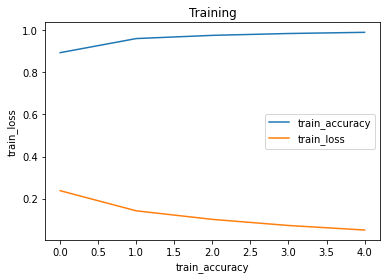

In [ ]:
epochline = np.array(range(epoch_ind+1))
plt.plot(epochline, train_accuracy_g, label="train_accuracy")
plt.plot(epochline, train_loss_g, label="train_loss")
plt.plot()

plt.xlabel("train_accuracy")
plt.ylabel("train_loss")
plt.title("Training")
plt.legend()
plt.show()

In [ ]:
model.eval()
val_accuracy, val_loss = [], []
for (X, Y) in val_dl:
  #X, Y = X.to(device), Y.to(device)
  Y_pred = model(X)
  loss = loss_fn(Y_pred, Y.float().unsqueeze(1))

  Y_p = F.threshold(Y_pred, 0.5, 0)
  Y_p = -F.threshold(-Y_p, -0.5, -1)
  Y_p = Y_p.to(torch.int32)
  Y_t = Y.unsqueeze(1).to(torch.int32)

  accuracy = (Y_p == Y_t).float().mean()    

  val_accuracy.append(accuracy)
  val_loss.append(loss.detach())
print(f"EVAL: loss={torch.stack(val_loss).mean():.6f}\tacc={torch.stack(val_accuracy).mean():.5f}\n")

EVAL: loss=0.151050	acc=0.96354

